In [228]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot as plt

In [22]:
# Loading data
measures = pd.read_csv("../data/measures_database.csv", sep=';', encoding='utf8')
stock_it = pd.read_csv("../data/FTSE_MIB_large.csv", sep='\t', encoding='utf7')

In [23]:
# Cleaning
measures = measures.dropna(axis='rows', subset=['DATE_IMPLEMENTED'])
measures = measures.dropna(axis='columns', how='all')
measures['DATE_IMPLEMENTED'] = pd.to_datetime(measures['DATE_IMPLEMENTED'], dayfirst=True)

measures = measures[measures['LOG_TYPE'] != "Phase-out measure"] # Not looking at phasing out atm

measures.MEASURE = measures['MEASURE'].str.split().str.join(' ') # remove HTML \xa0
measures = measures[measures['MEASURE'] != 'Strengthening the public health system']
measures = measures[measures['MEASURE'] != 'Economic measures']
measures = measures[measures['MEASURE'] != 'Awareness campaigns']
measures = measures[measures['MEASURE'] != 'Psychological assistance and medical social work']
measures = measures[measures['MEASURE'] != 'Changes in prison-related policies']
measures = measures[measures['MEASURE'] != 'Other public health measures enforced']

measures.sort_values(by='DATE_IMPLEMENTED',ascending=True, inplace=True)


stock_it['Date'] = pd.to_datetime(stock_it['Date'])
stock_it.sort_values(by='Date',ascending=True, inplace=True)
stock_it.reset_index(inplace=True)

In [24]:
# Selecting
country_name = 'Italy'

measures_it = measures[measures['COUNTRY'] == country_name]
measures_it.reset_index(inplace=True)

In [35]:
# Get subset needed
measure_w_date = measures_it[['DATE_IMPLEMENTED', 'MEASURE']]
measure_w_date = measure_w_date.rename(columns={'DATE_IMPLEMENTED': 'Date', 'MEASURE': 'Measure'})
stock_w_date = stock_it[["Date", "Price"]]

In [412]:
#setting index
# stock_w_date.index = stock_w_date.Date
# stock_w_date.drop('Date', axis=1, inplace=True)

In [507]:
measure_to_check_index = 13
print("Calculate for measure: %s" % (measure_w_date['Measure'][measure_to_check_index]))
print("On Date: %s" % (measure_w_date['Date'][measure_to_check_index]))
index_measure = stock_w_date.index[stock_w_date['Date'] == measure_w_date['Date'][measure_to_check_index]][0]

Calculate for measure: Limit public gatherings
On Date: 2020-03-09 00:00:00


In [494]:
# Creating train and test sets
dataset = pd.DataFrame(stock_w_date.Price)
dataset.index = stock_w_date.Date
# dataset = dataset.reshape(-1,1)

look_back_days = 50
train = dataset[:index_measure]
valid = dataset[(index_measure-1):]

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train = scaler.fit_transform(train)

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)

x_train, y_train = [], []
for i in range(look_back_days,len(train)):
    x_train.append(scaled_train[i-look_back_days:i,0])
    y_train.append(scaled_train[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

Train on 249 samples
Epoch 1/2
249/249 - 9s - loss: 0.1516
Epoch 2/2
249/249 - 5s - loss: 0.0589


In [495]:
days_to_look_ahead = 40
data_leakage = True

if days_to_look_ahead > len(valid):
    days_to_look_ahead = len(valid)

x_test = x_train[-1]
x_test = np.reshape(x_test, (1,x_test.shape[0],1))

price_result = []
diff_result = []
for i in range(days_to_look_ahead):
    closing_price = model.predict(x_test)
    
    actual_price = valid.iloc[i].Price
    actual_price = scaler.transform([[actual_price]])
    
    diff_result.append(closing_price - actual_price)
    
    if data_leakage:
        new_price = np.mean([closing_price, actual_price])
    else:
        new_price = closing_price

    price_result.append(scaler.inverse_transform(closing_price))
    
    prev_x_test = x_test[-1][1:]
    x_test = np.append(prev_x_test, new_price)
    x_test = np.reshape(x_test, (1,x_test.shape[0],1))


In [496]:
prediction = valid.head(len(price_result))
prediction['Price'] = price_result

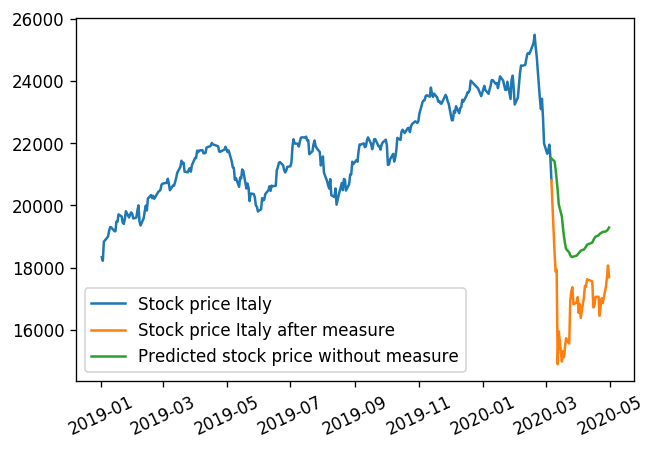

In [497]:
plt.figure(dpi=120)
plt.plot(train['Price'], label='Stock price Italy')
plt.plot(valid['Price'], label='Stock price Italy after measure')
plt.plot(prediction, label='Predicted stock price without measure')

plt.xticks(rotation=25)
plt.legend()

plt.rcParams['savefig.dpi'] = 120
plt.savefig('stock_price_measure_14.png')